In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.metrics import r2_score, mean_absolute_error


original_data = pd.read_excel('data/owid-covid-data.xlsx')
unique_countries = list(set(original_data['location']))
country_splitted_data = {}
for country in unique_countries:
    country_data = original_data[original_data['location']==country]
    country_data['date'] = pd.to_datetime(country_data['date'])
    country_data = country_data[['date', 'total_cases_per_million', 'new_cases_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'total_tests_per_thousand', 'new_tests_per_thousand']]
    country_splitted_data[country] = country_data


mobility_data = pd.read_csv('data/Global_Mobility_Report.csv')

unique_mobility_countries = list(set(mobility_data['country_region']))
country_splitted_mobility = {}
for country in unique_mobility_countries:
    country_data = mobility_data[mobility_data['country_region']==country]
    country_data['date'] = pd.to_datetime(country_data['date'])
    country_data = country_data[pd.isna(country_data['sub_region_1']) &pd.isna(country_data['sub_region_2']) & pd.isna(country_data['metro_area'])]
    country_splitted_mobility[country] = country_data



countries_of_interest = ['South Korea', 'United States', 'Canada', 'United Kingdom', 'Germany', 'Japan', 'France', 'Italy', 'India']



In [2]:

N = 7
if not os.path.exists('mobility_pca'):
    os.mkdir('mobility_pca')

columns_of_interest = ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline'] 

In [3]:
pc_overall_data = None
for country in country_splitted_mobility.keys():
    country_smoothed = country_splitted_mobility[country][columns_of_interest].rolling(N).mean()
    country_smoothed = country_smoothed.dropna()
    if len(country_smoothed) > 200:
        np_data = country_smoothed.to_numpy()

    if pc_overall_data is None:
        pc_overall_data = np_data
    else:    
        pc_overall_data = np.concatenate([pc_overall_data, np_data], axis=0)   


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA


grand_pca = PCA(2)
new_overall_data = grand_pca.fit_transform(pc_overall_data)
print(grand_pca.explained_variance_ratio_)

# total explained variance ratio is equal to the variance-weighted reconstruction R2
print(np.sum(grand_pca.explained_variance_ratio_))
print(r2_score(pc_overall_data, grand_pca.inverse_transform(grand_pca.transform(pc_overall_data)),multioutput='variance_weighted'))

[0.89455717 0.04154437]
0.9361015369558379
0.9361015369558368


In [5]:
print(grand_pca.components_)

[[ 0.5752627   0.40713081  0.54366672  0.40791485 -0.20334527]
 [ 0.28854411  0.67866054 -0.48858748 -0.46254936 -0.05909761]]


South Korea
R2 reconstruction overall: 
0.6651006762919046
R2 reconstruction of last 100 days: 
0.6643947616817534


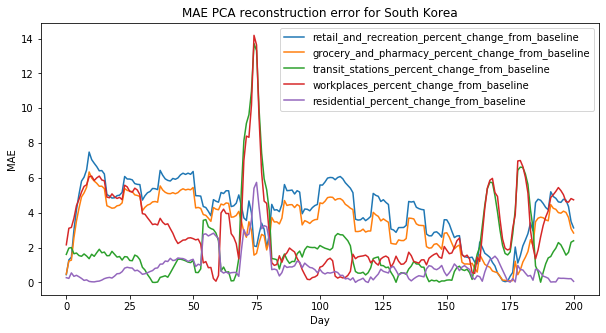

United States
R2 reconstruction overall: 
0.9082778634152274
R2 reconstruction of last 100 days: 
-8.609236636328735


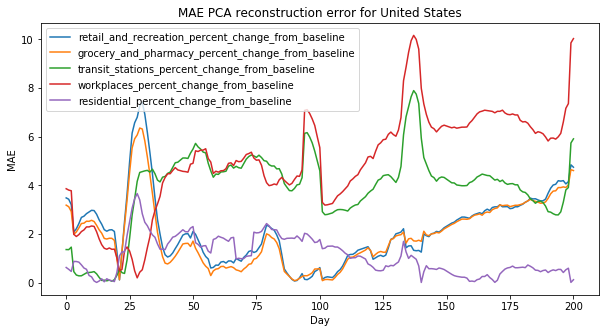

Canada
R2 reconstruction overall: 
0.9751713244240386
R2 reconstruction of last 100 days: 
0.4047450854641755


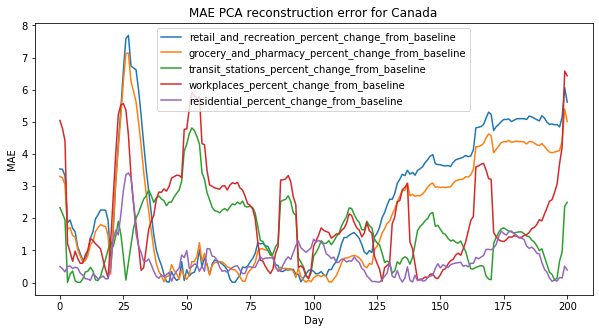

United Kingdom
R2 reconstruction overall: 
0.9020005544435848
R2 reconstruction of last 100 days: 
0.4572976057023375


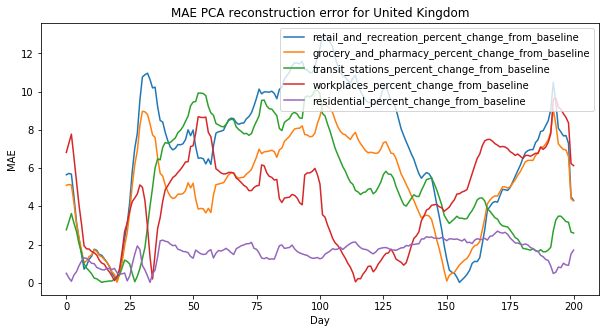

Germany
R2 reconstruction overall: 
0.8918010586190237
R2 reconstruction of last 100 days: 
0.15937287606597908


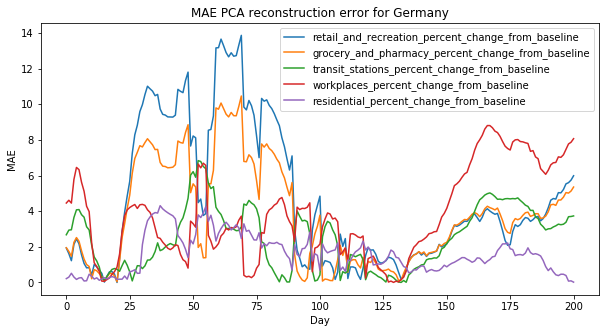

Japan
R2 reconstruction overall: 
0.8244662763253285
R2 reconstruction of last 100 days: 
0.13465086776909577


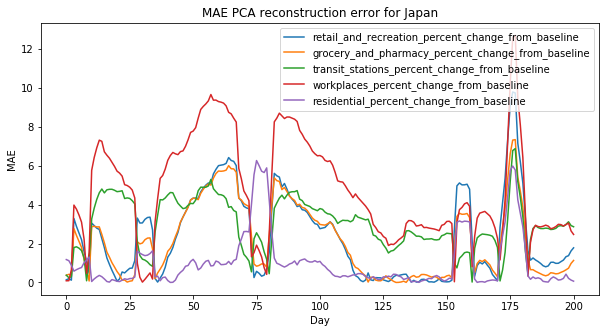

France
R2 reconstruction overall: 
0.9525513482881967
R2 reconstruction of last 100 days: 
-0.1356553265071361


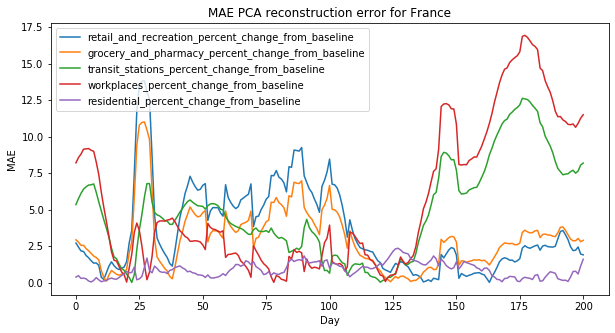

Italy
R2 reconstruction overall: 
0.9547600202834085
R2 reconstruction of last 100 days: 
-0.36369539077473556


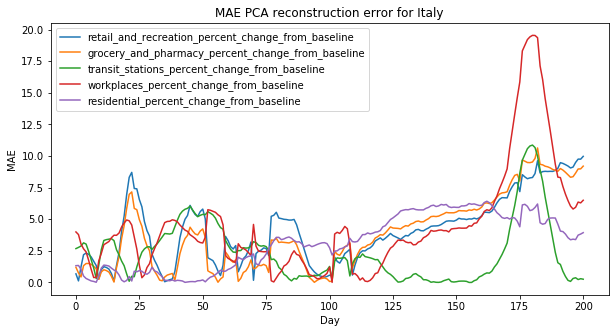

India
R2 reconstruction overall: 
0.7924642980632217
R2 reconstruction of last 100 days: 
-7.633034947180139


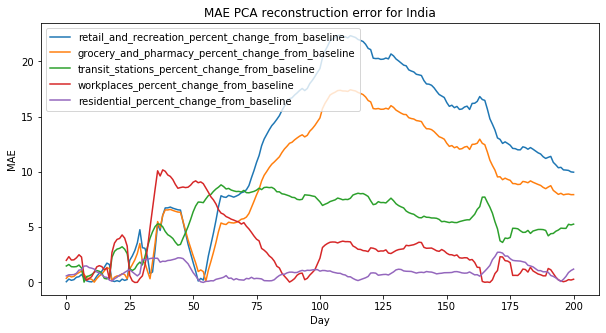

In [6]:
for country in countries_of_interest:
    country_smoothed = country_splitted_mobility[country][columns_of_interest].rolling(N).mean()
    country_smoothed = country_smoothed.dropna()
    if len(country_smoothed) > 200:
        np_data = country_smoothed.to_numpy()

    plt.figure(figsize=(10, 5))
    plt.title('MAE PCA reconstruction error for ' +country)
    pca_reconstructions =grand_pca.inverse_transform(grand_pca.transform(np_data))
    reconstruction_accs = np.abs(np_data - pca_reconstructions)
    plt.xlabel('Day')
    plt.ylabel('MAE')

    print(country)

    print('R2 reconstruction overall: ')
    print(r2_score(pca_reconstructions, np_data, multioutput='variance_weighted'))
    print('R2 reconstruction of last 100 days: ')
    print(r2_score(pca_reconstructions[-100:], np_data[-100:], multioutput='variance_weighted'))
    for i, col in enumerate(columns_of_interest):
        plt.plot(reconstruction_accs[:, i], label = col)
    plt.legend()
    plt.show()

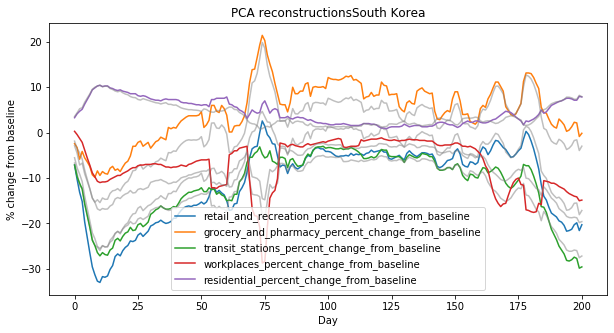

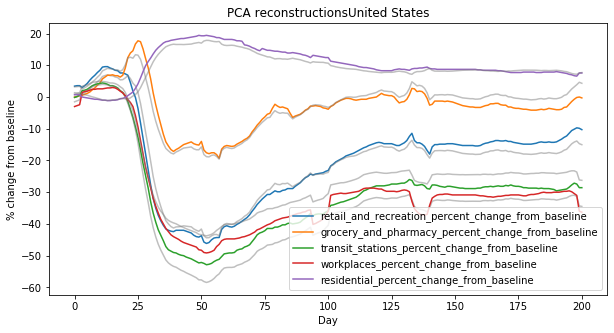

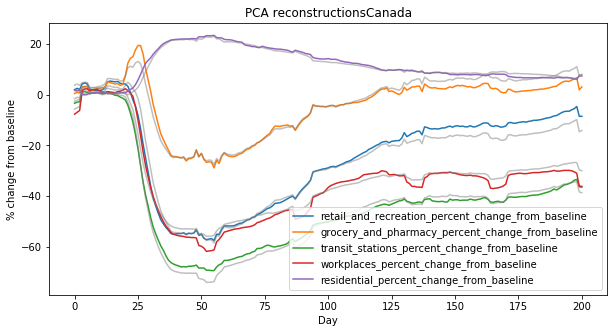

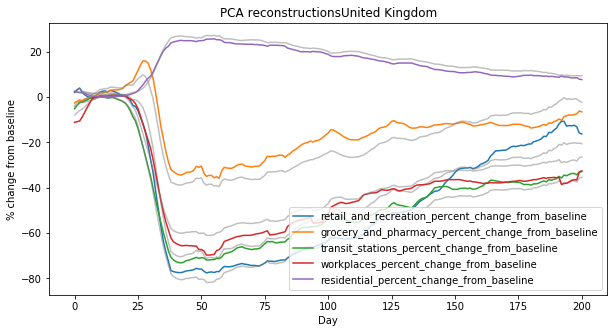

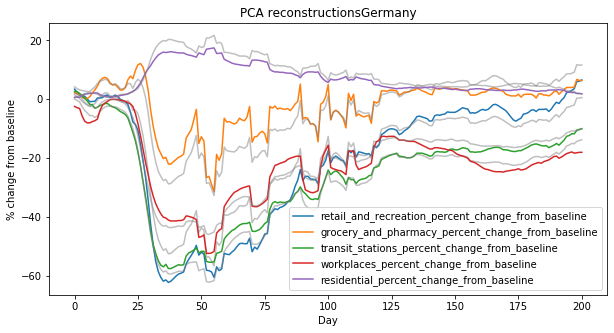

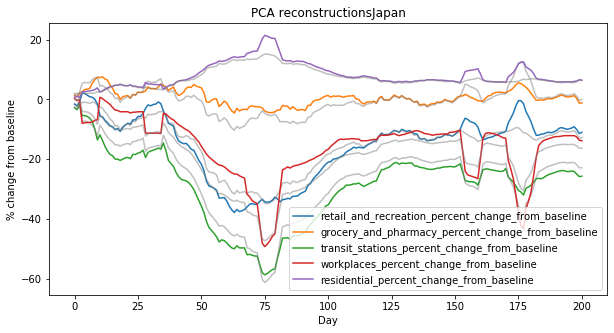

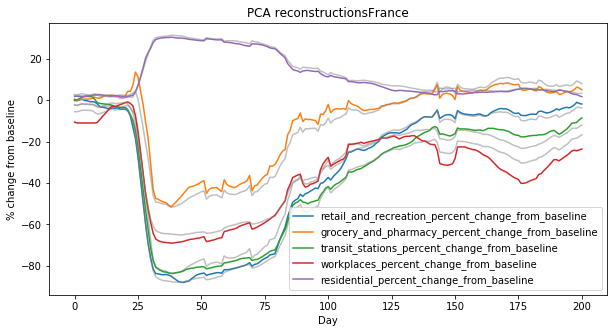

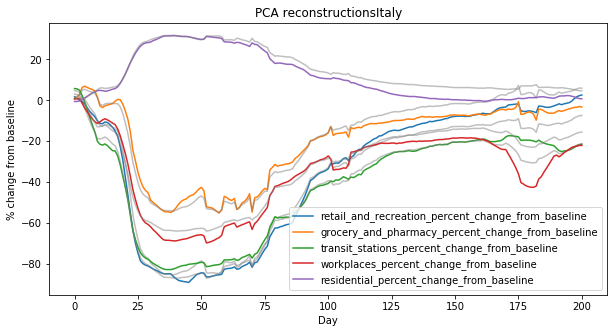

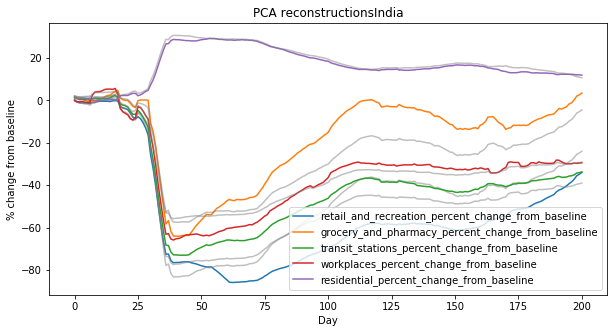

In [9]:
for country in countries_of_interest:
    country_smoothed = country_splitted_mobility[country][columns_of_interest].rolling(N).mean()
    country_smoothed = country_smoothed.dropna()
    if len(country_smoothed) > 200:
        np_data = country_smoothed.to_numpy()

    plt.figure(figsize=(10, 5))
    plt.title('PCA reconstructions' +country)
    pca_reconstructions =grand_pca.inverse_transform(grand_pca.transform(np_data)) 
    reconstruction_accs = np.abs(np_data - pca_reconstructions)
    plt.xlabel('Day')
    plt.ylabel('% change from baseline')

    for i, col in enumerate(columns_of_interest):
        plt.plot(np_data[:, i], label=col)
        plt.plot(pca_reconstructions[:, i], alpha=0.5, color='grey')
        
    plt.legend()
    plt.show()

In [8]:
from pickle import dump
dump(grand_pca, open('grand_pca.pickle', 'wb'))